In [1]:
import gym
import gym_abalone

import random
from copy import deepcopy
from tqdm.notebook import tqdm
import numpy as np

import torch
import torch.nn as nn

# Abalone MCTS / AlphaZero tests

See the implementation of the environment in the [original repository](https://github.com/towzeur/gym-abalone) by **towzeur**. Game rules, action representation, state representation, reward function design is not changed here, read about it in towzeur's readme page.

# Environment

Let's start by learning to work with this environment. We'll do the following changes:
* originally env takes two numbers as action, representing starting point and target point. We'll switch to standard int as an action.
* observations, actions and reward functions are now mirrored, so that on each step every player thinks he is playing white. Yet player with index 0 *maximizes* reward, player 1 *minimizes* reward.

In [2]:
class CustomWrapper(gym.Wrapper):
    def step(self, a):
        # this is just how it is encoded in this implementation of env
        go_from, go_where = self.mirror_action(a // 61, a % 61)
        player = self.env.game.current_player
        
        s, r, done, info = self.env.step((go_from, go_where))
        self.latest_observation = self.mirror_observation(s)
        return self.latest_observation, self.mirror_reward(r, player), done, info
    
    def reset(self):
        s = self.env.reset()
        self.latest_observation = self.mirror_observation(s)
        return self.latest_observation
        
    def mirror_observation(self, s):
        # if current player is playing black, switch white to black and shift the board
        if self.env.game.current_player == 0:
            return s[None]
        
        s[s == 0] = 5
        s[s == 1] = 0
        s[s == 5] = 1
        return s[None, ::-1, ::-1]
    
    def mirror_action(self, go_from, go_where):
        if self.env.game.current_player == 0:
            return go_from, go_where
        
        # turns out it is quite convenient
        return 60 - go_from, 60 - go_where
    
    def mirror_reward(self, r, player):
        return r if player == 0 else -r
    
    def get_mirrored_action_mask(self):
        """
        This function is also reloaded to behave like player is always playing white.
        Modified original code from original env;
        
        Returns: action mask which as a 61*61 = 3721 numpy vector
                 with 0 and 1. 0 if the action is illegal and 1 otherwise.
        """
        player = self.game.current_player
        possible_moves = self.game.get_possible_moves(player, group_by_type=False)
        idx_from_move = lambda p0, p1: p0*61 + p1
        possible_index = np.array([idx_from_move(*self.mirror_action(p0, p1)) for p0,p1 in possible_moves])
        action_mask = np.zeros(61**2)
        action_mask[possible_index] = np.ones(possible_index.shape)
        return action_mask
    
    def render(self, fps=None):
        self.env.render(fps=None if fps is None else 1/fps)  # error in original repository, fps was inverted

In [5]:
env = CustomWrapper(gym.make("abalone-v0"))

In [6]:
s = env.reset()

State representation:
* -2 is not a part of board
* -1 is empty cell
* 0 is white ball ("our")
* 1 is black ball ("enemy")

Board is actually hexagonal!

In [8]:
s

array([[[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
        [-2, -2, -2, -2, -2,  1,  1,  1,  1,  1, -2],
        [-2, -2, -2, -2,  1,  1,  1,  1,  1,  1, -2],
        [-2, -2, -2, -1, -1,  1,  1,  1, -1, -1, -2],
        [-2, -2, -1, -1, -1, -1, -1, -1, -1, -1, -2],
        [-2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -2],
        [-2, -1, -1, -1, -1, -1, -1, -1, -1, -2, -2],
        [-2, -1, -1,  0,  0,  0, -1, -1, -2, -2, -2],
        [-2,  0,  0,  0,  0,  0,  0, -2, -2, -2, -2],
        [-2,  0,  0,  0,  0,  0, -2, -2, -2, -2, -2],
        [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]]], dtype=int8)

In [10]:
# so, state input is an image with 1 channel
# (no memory of previous states is required)
s.shape

(1, 11, 11)

In [11]:
# this is the index of player, who has to make next move
env.game.current_player

0

In [12]:
# mask of possible actions
env.get_mirrored_action_mask()

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
env.get_action_mask().nonzero()

(array([2782, 2783, 2784, 2785, 2789, 2793, 2843, 2844, 2845, 2846, 2850,
        2854, 2904, 2905, 2906, 2907, 2911, 2915, 3093, 3094, 3148, 3149,
        3154, 3155, 3209, 3211, 3271, 3273, 3333, 3334, 3342, 3343, 3403,
        3404, 3454, 3459, 3516, 3521, 3575, 3578, 3637, 3647, 3699, 3709],
       dtype=int64),)

In [14]:
# number of possible moves
env.get_action_mask().sum()

44.0

In [15]:
# let's play
env.reset()
done = False

while not done:
    # select random action
    action = random.choice(env.get_mirrored_action_mask().nonzero()[0])
    
    # reward is given to the player who sent this action
    obs, reward, done, _ = env.step(action)
    
    # this will show a visualisation, fps limits how fast it will show moves
    env.render(fps=5)

In [16]:
env.close()

# Models

Let's just use some architecture for NN like in AlphaZero. There should be two heads: one for V-function approximation V(s) and one approximation of policy p(a | s).

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
N_ACTIONS = 3721

In [19]:
class AbaloneNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2592, 512),
            nn.ReLU()
        )
        
        self.policy_head = nn.Linear(512, N_ACTIONS)
        self.value_head = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.layers(x)
        return self.policy_head(x), self.value_head(x).squeeze(-1)
    
    def apply(self, x, allowed_actions):
        '''
        Works with numpy input and numpy output
        
        input: x - single state, numpy
               allowed_actions - numpy, mask of allowed actions
               
        output: policy - numpy, vector of probabilities; probabilities of impossible actions are 0
                V      - scalar, approximation of future rewards
        
        '''
        inp = torch.FloatTensor([x]).to(device)
        prior_policy, critic_estimation = self.forward(inp)
        critic_estimation = critic_estimation[0].cpu().numpy()
        
        prior_policy = prior_policy[0].cpu().numpy()
        prior_policy = np.exp(prior_policy)      # custom softmax        
        prior_policy *= allowed_actions          # masking impossible actions
        prior_policy /= prior_policy.sum()       # normalizing
        return prior_policy, critic_estimation

In [20]:
# testing just in case
model = AbaloneNN()
inp = torch.Tensor(size=(10,1,11,11)).uniform_()
output = model(inp)
assert len(output) == 2
assert output[0].shape == (10, N_ACTIONS)
assert output[1].shape == (10,)

# MCTS

Let's create AlphaZero-like MCTS procedure.

In [22]:
class Node:
    """A tree node for MCTS."""

    def __init__(self, player, parent=None, action=None, prior_proba=None):
        """
        Creates and empty node with no children.
        input: player - index of player, who selects action in this node
               parent - reference to parent node, or None if this is root
               action - action selected from parent node to this node
               prior_proba - scalar, output of model p(a | s)
        """

        self.parent = parent
        self.action = action
        self.player = player
        self.children = set()  # set of child nodes
        
        self.qvalue_sum = 0.      # sum of Q-values from all visits (numerator)
        self.times_visited = 0    # counter of visits (denominator)
        self.immediate_reward = 0 # r(parent_node, self.action)
        self.is_done = False      # if true, this node is leaf and no action choise is performed from here
        
        self.prior_policy_probability = prior_proba  # probability of this action to be chosen p(a | s)

    def is_leaf(self):
        return len(self.children) == 0

    def is_root(self):
        return self.parent is None

    def get_qvalue_estimate(self, player):
        q = self.qvalue_sum / self.times_visited if self.times_visited != 0 else 0
        return q if player == 0 else -q  # player 1 wants to minimize our reward

    def ucb_score(self, player, scale=10, max_value=1e100):
        """
        Computes ucb1 upper bound using current value and visit counts for node and it's parent.

        input: player: index of player, for which ucb score is computed (actually it is self.parent.player always o_O)
               scale: Multiplies upper bound by that. From Hoeffding inequality,
                      assumes reward range to be [0, scale].
               max_value: a value that represents infinity (for unvisited nodes).

        """

        if self.times_visited == 0:
            return max_value

        # computing exploration bonus, UCB bandits inspired
        # self.parent.times_visited is number of times parent node was considered
        # self.times_visited is number of times this node was visited

        U = self.prior_policy_probability * (self.parent.times_visited**0.5) / (self.times_visited + 1)

        return self.get_qvalue_estimate(player) + scale * U

    def select_best_leaf(self, simulator):
        """
        Picks the leaf with the highest priority to expand.
        Does so by recursively picking nodes with the best UCB-1 score until it reaches a leaf.
        """
        if not self.is_root():            
            _, self.immediate_reward, self.is_done, _ = simulator.step(self.action)
        
        if self.is_leaf():
            return self

        # Select the child node with the highest UCB score. 
        # Argmax selected randomly to break ties in a smart way.
        best_score = max(child.ucb_score(self.player) for child in self.children)
        candidates = [child for child in self.children if child.ucb_score(self.player) == best_score]
        best_child = random.choice(candidates)

        return best_child.select_best_leaf(simulator)

    def expand(self, model, simulator):
        """
        Expands the current node by creating all possible child nodes.
        Returns estimation of future reward
        """
        if self.is_done:
            return 0
        
        allowed_actions = simulator.get_mirrored_action_mask()
        
        with torch.no_grad():
            prior_policy, critic_estimation = model.apply(simulator.latest_observation, allowed_actions)

        for action in allowed_actions.nonzero()[0]:
            self.children.add(Node(player=int(not self.player), 
                                   parent=self, 
                                   action=action, 
                                   prior_proba=prior_policy[action]))
            
        return critic_estimation

    def propagate(self, child_qvalue):
        """
        Uses child Q-value (sum of rewards) to update parents recursively.
        """
        # update qvalue_sum and times_visited
        self.qvalue_sum += child_qvalue
        self.times_visited += 1

        # propagate upwards
        if not self.is_root():
            self.parent.propagate(self.immediate_reward + child_qvalue)

In [23]:
class MCTS():
    '''
    Class for MCTS strategy
    '''
    def __init__(self):        
        self.model = AbaloneNN().to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        
    def save(self, PATH):
        torch.save(self.model.state_dict(), PATH)
        torch.save(self.optimizer.state_dict(), PATH + "_optimizer")
        
    def load(self, PATH):
        self.model.load_state_dict(torch.load(PATH))
        self.optimizer.load_state_dict(torch.load(PATH + "_optimizer"))
        
    def clear_tree(self, starting_player):
        self.root = Node(player=starting_player)
        
    def plan(self, simulator):
        '''
        Performs 1 selection-expansion-backpropagation iteration of MCTS planning procedure
        '''
        leaf = self.root.select_best_leaf(simulator)
        future_reward = leaf.expand(self.model, simulator)
        leaf.propagate(future_reward)
        
    def get_policy(self, temperature=1):
        '''
        Returns an exploratory (non-greedy) policy based on visitation counters
        '''
        probas = np.zeros(N_ACTIONS)
        for child in self.root.children:
            probas[child.action] = child.times_visited**temperature
        probas /= probas.sum()
        return probas
    
    def root_from_subtree(self, action):
        '''
        Cuts subtree corresponding to given action
        '''
        for child in self.root.children:
            if child.action == action:
                self.root = child
                self.root.parent, self.root.action = None, None
                self.root.immediate_reward = 0
                print(f"new root was visited {self.root.times_visited} times")
                assert not child.is_done
                return
        
        # if enemy, for example, selected an action that we never considered
        # can happen of the first turn, when MCTS is not given a chance to plan
        print("this node was never visited")
        self.clear_tree(not self.root.player)
        
    def launch_NN_policy(self, obs, allowed_actions):
        '''
        Select action using fast NN policy
        output: action - int
        '''
        with torch.no_grad():
            prior_policy, _ = self.model.apply(obs, allowed_actions)
            return np.random.choice(np.arange(N_ACTIONS), p=prior_policy)

# Let's play

Let's try our MCTS policy! We will plan for 1000 MCTS steps before selecting action for white player. Black player will play randomly.

In [24]:
from tqdm import tqdm_notebook as tqdm

def play_game_against_random_actor(env, mcts, n_iter=1000):
    # initialization
    s = env.reset()
    renderer_env = deepcopy(env)  # we will create simulator by deepcopying env, so there shoud be no GUI inside env
    done = False
    t = 0
    R = 0
    mcts.clear_tree(env.game.current_player)
    
    # playing
    while not done:
        if env.game.current_player == 0:
            # planning
            for _ in tqdm(range(n_iter)):
                simulator = deepcopy(env)
                mcts.plan(simulator)
            
            # get MCTS policy
            mcts_policy = mcts.get_policy()
            print("Policy probas: ", mcts_policy[mcts_policy > 0])
            
            # sampling from it
            action = np.random.choice(np.arange(N_ACTIONS), p=mcts_policy)
        else:
            action = random.choice(env.get_mirrored_action_mask().nonzero()[0])
        
        s, r, done, _ = env.step(action)
        print("Reward per step:", r)
        t += 1
        R += r
        
        # cutting MCTS subtree
        if not done:
            mcts.root_from_subtree(action)
        
        # rendering (render_env is given the same action)
        renderer_env.step(action)
        renderer_env.render()
    
    # destroying GUI
    renderer_env.close()
    
    # output: total reward, number of timesteps
    return R, t

In [25]:
env = CustomWrapper(gym.make("abalone-v0"))
mcts = MCTS()

In [26]:
play_game_against_random_actor(env, mcts)

<ipython-input-24-1a5521b25766>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(n_iter)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.02202202 0.02202202 0.02202202 0.02302302 0.02302302 0.02302302
 0.02302302 0.02202202 0.02202202 0.02302302 0.02302302 0.02102102
 0.02302302 0.02302302 0.02302302 0.02202202 0.02302302 0.02302302
 0.02102102 0.02302302 0.02302302 0.02302302 0.02402402 0.02202202
 0.02302302 0.02202202 0.02402402 0.02302302 0.02202202 0.02302302
 0.02202202 0.02302302 0.02402402 0.02302302 0.02302302 0.02402402
 0.02302302 0.02302302 0.02402402 0.02302302 0.02202202 0.02102102
 0.02302302 0.02202202]
Reward per step: -0.1
new root was visited 23 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01701702 0.01901902 0.01801802 0.01801802 0.01801802 0.01801802
 0.01801802 0.01701702 0.01801802 0.01801802 0.01801802 0.01801802
 0.01901902 0.01901902 0.01801802 0.01801802 0.01801802 0.01901902
 0.01801802 0.01701702 0.01701702 0.01801802 0.01801802 0.01901902
 0.01801802 0.01801802 0.01901902 0.01801802 0.01701702 0.01801802
 0.01901902 0.01901902 0.01901902 0.01801802 0.01801802 0.01901902
 0.01801802 0.01801802 0.01801802 0.01801802 0.01801802 0.01901902
 0.01901902 0.01901902 0.01901902 0.01801802 0.01901902 0.01801802
 0.01801802 0.01801802 0.01701702 0.01801802 0.01901902 0.01701702
 0.01801802]
Reward per step: -0.1
new root was visited 18 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01701702 0.01701702 0.01801802 0.01801802 0.01801802 0.01701702
 0.01901902 0.01501502 0.01201201 0.01801802 0.01701702 0.01801802
 0.01701702 0.01701702 0.01701702 0.01701702 0.01801802 0.01801802
 0.01701702 0.01701702 0.01701702 0.01801802 0.01701702 0.01801802
 0.01801802 0.01801802 0.01801802 0.01601602 0.01701702 0.01801802
 0.01801802 0.01801802 0.01901902 0.01701702 0.01801802 0.01801802
 0.01801802 0.01801802 0.01701702 0.01801802 0.01801802 0.01801802
 0.01701702 0.01801802 0.01801802 0.01801802 0.01901902 0.01901902
 0.01701702 0.01801802 0.01801802 0.01701702 0.01901902 0.01701702
 0.01701702 0.01701702 0.01801802]
Reward per step: -0.1
new root was visited 18 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01501502 0.01501502 0.01401401 0.01601602 0.01601602 0.01501502
 0.01501502 0.01501502 0.01601602 0.01601602 0.01601602 0.01501502
 0.01501502 0.01501502 0.01601602 0.01501502 0.01601602 0.01501502
 0.01601602 0.01701702 0.01601602 0.01501502 0.01601602 0.01601602
 0.01701702 0.01601602 0.01501502 0.01601602 0.01501502 0.01501502
 0.01501502 0.01601602 0.01301301 0.01601602 0.01501502 0.01601602
 0.01601602 0.01601602 0.01501502 0.01601602 0.01601602 0.01701702
 0.01601602 0.01601602 0.01501502 0.01601602 0.01601602 0.01601602
 0.01501502 0.01601602 0.01601602 0.01701702 0.01601602 0.01601602
 0.01701702 0.01501502 0.01501502 0.01601602 0.01501502 0.01501502
 0.01501502 0.01601602 0.01501502 0.01601602]
Reward per step: -0.1
new root was visited 15 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01401401 0.01501502 0.01601602 0.01601602 0.01501502 0.01401401
 0.01301301 0.01501502 0.01501502 0.01501502 0.01501502 0.01401401
 0.01601602 0.01601602 0.01501502 0.01501502 0.01501502 0.01501502
 0.01501502 0.01501502 0.01501502 0.01601602 0.01601602 0.01501502
 0.01401401 0.01601602 0.01601602 0.01501502 0.01501502 0.01501502
 0.01401401 0.01501502 0.01501502 0.01501502 0.01301301 0.01501502
 0.01501502 0.01601602 0.01501502 0.01401401 0.01601602 0.01601602
 0.01601602 0.01601602 0.01501502 0.01501502 0.01601602 0.01601602
 0.01501502 0.01501502 0.01501502 0.01601602 0.01601602 0.01601602
 0.01501502 0.01601602 0.01501502 0.01501502 0.01501502 0.01401401
 0.01501502 0.01501502 0.01501502 0.01501502 0.01501502 0.01601602]
Reward per step: -0.1
new root was visited 15 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.02002002 0.01801802 0.01801802 0.02002002 0.01901902 0.01701702
 0.01901902 0.01901902 0.01801802 0.01801802 0.01801802 0.02002002
 0.01901902 0.01901902 0.01901902 0.01401401 0.01901902 0.01901902
 0.01801802 0.01901902 0.01901902 0.02002002 0.01901902 0.01801802
 0.01901902 0.01901902 0.01901902 0.02002002 0.02002002 0.01901902
 0.01901902 0.01901902 0.01901902 0.01901902 0.01801802 0.01901902
 0.01901902 0.01901902 0.01801802 0.01901902 0.02002002 0.01901902
 0.02002002 0.02002002 0.01801802 0.01901902 0.02002002 0.01901902
 0.02002002 0.01801802 0.01901902 0.01801802 0.01901902]
Reward per step: -0.1
new root was visited 19 times
Reward per step: 0.1
new root was visited 1 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.017 0.016 0.015 0.017 0.016 0.016 0.017 0.016 0.016 0.014 0.016 0.016
 0.017 0.017 0.016 0.016 0.016 0.016 0.017 0.014 0.017 0.016 0.016 0.016
 0.017 0.016 0.016 0.017 0.017 0.015 0.016 0.017 0.016 0.017 0.018 0.017
 0.017 0.017 0.016 0.017 0.017 0.016 0.016 0.017 0.017 0.017 0.016 0.016
 0.017 0.018 0.016 0.017 0.017 0.016 0.017 0.016 0.016 0.015 0.017 0.017
 0.017]
Reward per step: -0.1
new root was visited 16 times
Reward per step: 0.1
new root was visited 1 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.02  0.017 0.018 0.021 0.019 0.017 0.02  0.019 0.019 0.019 0.016 0.017
 0.017 0.017 0.019 0.02  0.019 0.02  0.017 0.019 0.019 0.016 0.017 0.015
 0.018 0.016 0.014 0.017 0.017 0.018 0.019 0.016 0.02  0.017 0.018 0.02
 0.013 0.02  0.019 0.016 0.02  0.019 0.017 0.015 0.019 0.018 0.02  0.015
 0.018 0.016 0.018 0.019 0.019 0.021 0.013 0.018]
Reward per step: -0.1
new root was visited 19 times
Reward per step: 0.1
new root was visited 1 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.018 0.014 0.016 0.018 0.018 0.017 0.017 0.017 0.016 0.017 0.016 0.018
 0.017 0.016 0.017 0.017 0.017 0.018 0.016 0.017 0.017 0.018 0.018 0.018
 0.017 0.016 0.017 0.017 0.018 0.017 0.017 0.017 0.017 0.017 0.017 0.017
 0.017 0.017 0.017 0.017 0.016 0.017 0.018 0.017 0.016 0.016 0.017 0.017
 0.017 0.017 0.018 0.016 0.016 0.018 0.017 0.017 0.017 0.017 0.016]
Reward per step: -0.1
new root was visited 16 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01701702 0.01701702 0.01801802 0.01901902 0.01701702 0.01301301
 0.01701702 0.01401401 0.01701702 0.01701702 0.01801802 0.01701702
 0.01701702 0.01501502 0.01601602 0.01801802 0.01501502 0.01701702
 0.01601602 0.01501502 0.01601602 0.01501502 0.01501502 0.01501502
 0.01801802 0.01701702 0.01801802 0.01801802 0.01601602 0.01701702
 0.01801802 0.01801802 0.01701702 0.01801802 0.01601602 0.01601602
 0.01701702 0.01801802 0.01801802 0.01801802 0.01701702 0.01901902
 0.01801802 0.01701702 0.01501502 0.01801802 0.01601602 0.01501502
 0.01701702 0.01801802 0.01801802 0.01801802 0.01801802 0.01801802
 0.01701702 0.01801802 0.01801802 0.01701702 0.01801802]
Reward per step: -0.1
new root was visited 18 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01701702 0.01701702 0.01601602 0.01901902 0.01701702 0.01301301
 0.01401401 0.01601602 0.01701702 0.01801802 0.01801802 0.01701702
 0.01701702 0.01401401 0.01801802 0.01501502 0.01801802 0.01801802
 0.01601602 0.01701702 0.01501502 0.01501502 0.01301301 0.01801802
 0.01701702 0.01801802 0.01601602 0.01801802 0.01401401 0.01701702
 0.01801802 0.01601602 0.01701702 0.01801802 0.01801802 0.01801802
 0.01701702 0.01601602 0.01301301 0.01501502 0.01701702 0.01801802
 0.01701702 0.01501502 0.01501502 0.01801802 0.01701702 0.01501502
 0.01501502 0.01601602 0.01801802 0.01601602 0.01801802 0.01801802
 0.01701702 0.01901902 0.01901902 0.01701702 0.01701702 0.01801802]
Reward per step: -0.1
new root was visited 17 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01801802 0.01501502 0.01601602 0.01901902 0.01801802 0.01501502
 0.01601602 0.01801802 0.01401401 0.01901902 0.01801802 0.01701702
 0.01901902 0.01701702 0.01901902 0.01601602 0.01701702 0.01601602
 0.01801802 0.01401401 0.01601602 0.01501502 0.01501502 0.01801802
 0.01901902 0.01701702 0.01601602 0.01801802 0.01801802 0.01601602
 0.01701702 0.01801802 0.01601602 0.01801802 0.01701702 0.01801802
 0.01801802 0.01801802 0.01501502 0.01901902 0.01601602 0.01501502
 0.01801802 0.01501502 0.01501502 0.01601602 0.01501502 0.01801802
 0.01701702 0.01901902 0.01601602 0.01801802 0.01601602 0.01601602
 0.01901902 0.01701702 0.01701702 0.01701702 0.01801802]
Reward per step: -0.1
new root was visited 18 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01401401 0.01301301 0.01401401 0.01501502 0.01401401 0.01201201
 0.01001001 0.01301301 0.01401401 0.01201201 0.01101101 0.01301301
 0.01101101 0.01201201 0.01401401 0.01101101 0.01401401 0.01301301
 0.01501502 0.01501502 0.01201201 0.01401401 0.01401401 0.01401401
 0.01101101 0.01501502 0.01401401 0.01101101 0.01401401 0.01401401
 0.01201201 0.01401401 0.01401401 0.01301301 0.01301301 0.01501502
 0.01401401 0.01401401 0.01501502 0.01201201 0.01401401 0.01501502
 0.01501502 0.01401401 0.01401401 0.01201201 0.01401401 0.01501502
 0.01401401 0.01201201 0.01401401 0.01401401 0.01201201 0.01401401
 0.01501502 0.01401401 0.01401401 0.01201201 0.01201201 0.01401401
 0.01201201 0.01401401 0.01401401 0.01301301 0.01501502 0.01401401
 0.01401401 0.01501502 0.01401401 0.01501502 0.01401401 0.01401401
 0.01401401 0.01401401]
Reward per step: -0.1
new root was visited 14 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01501502 0.01201201 0.01601602 0.01601602 0.01501502 0.01601602
 0.01201201 0.01401401 0.01501502 0.01301301 0.01501502 0.01201201
 0.01501502 0.01301301 0.01301301 0.01601602 0.01601602 0.01401401
 0.01101101 0.01501502 0.01301301 0.01401401 0.01501502 0.01601602
 0.01601602 0.01501502 0.01401401 0.01601602 0.01301301 0.01401401
 0.01501502 0.01501502 0.01501502 0.01301301 0.01601602 0.01501502
 0.01301301 0.01601602 0.01501502 0.01301301 0.01601602 0.01401401
 0.01501502 0.01301301 0.01601602 0.01601602 0.01501502 0.01301301
 0.01301301 0.01601602 0.01501502 0.01601602 0.01301301 0.01301301
 0.01501502 0.01501502 0.01501502 0.01401401 0.01501502 0.01301301
 0.01201201 0.01401401 0.01501502 0.01501502 0.01601602 0.01501502
 0.01601602 0.01401401 0.01501502]
Reward per step: -0.1
new root was visited 15 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01401401 0.01401401 0.01501502 0.01601602 0.01401401 0.01501502
 0.01301301 0.01601602 0.01501502 0.01201201 0.01401401 0.01401401
 0.01501502 0.01201201 0.01201201 0.01301301 0.01201201 0.01201201
 0.01301301 0.01601602 0.01501502 0.01401401 0.01401401 0.01301301
 0.01201201 0.01301301 0.01501502 0.01501502 0.01201201 0.01401401
 0.01201201 0.01401401 0.01501502 0.01501502 0.01201201 0.01401401
 0.01301301 0.01301301 0.01401401 0.01501502 0.01301301 0.01201201
 0.01501502 0.01501502 0.01501502 0.01401401 0.01201201 0.01501502
 0.01201201 0.01401401 0.01301301 0.01201201 0.01301301 0.01201201
 0.01401401 0.01401401 0.01501502 0.01601602 0.01301301 0.01201201
 0.01001001 0.01201201 0.01001001 0.01401401 0.01201201 0.01501502
 0.01201201 0.01401401 0.01501502 0.00900901 0.01501502 0.01401401
 0.01201201 0.01301301]
Reward per step: -0.1
new root was visited 15 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01401401 0.01301301 0.01201201 0.01501502 0.01401401 0.01401401
 0.01001001 0.01501502 0.01101101 0.01401401 0.01401401 0.01201201
 0.01301301 0.01401401 0.01401401 0.01401401 0.01401401 0.01501502
 0.01501502 0.01201201 0.01401401 0.01301301 0.01401401 0.01301301
 0.01301301 0.01401401 0.01401401 0.01101101 0.01101101 0.01401401
 0.01401401 0.01101101 0.01201201 0.01401401 0.01101101 0.01201201
 0.01401401 0.01201201 0.01101101 0.01301301 0.01401401 0.01401401
 0.01401401 0.01501502 0.01401401 0.01401401 0.01401401 0.01401401
 0.01101101 0.01401401 0.01401401 0.01501502 0.01301301 0.01101101
 0.01401401 0.01401401 0.01501502 0.01401401 0.01101101 0.01101101
 0.01001001 0.01501502 0.01201201 0.01301301 0.01001001 0.01101101
 0.01401401 0.01301301 0.01301301 0.01501502 0.01201201 0.01301301
 0.01201201 0.01401401 0.01401401 0.01401401]
Reward per step: -0.1
new root was visited 14 times
Reward per step: 0.1
new root was visited 1 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.013 0.01  0.013 0.014 0.013 0.013 0.012 0.011 0.013 0.013 0.013 0.012
 0.01  0.011 0.01  0.01  0.013 0.013 0.01  0.013 0.013 0.011 0.013 0.014
 0.013 0.013 0.01  0.013 0.013 0.012 0.01  0.013 0.013 0.013 0.012 0.01
 0.013 0.013 0.013 0.013 0.014 0.012 0.013 0.013 0.013 0.01  0.011 0.009
 0.011 0.01  0.013 0.013 0.013 0.013 0.013 0.011 0.014 0.013 0.013 0.01
 0.013 0.012 0.013 0.013 0.013 0.008 0.013 0.011 0.012 0.014 0.012 0.011
 0.013 0.013 0.012 0.014 0.013 0.013 0.011 0.01  0.013 0.013]
Reward per step: -0.1
new root was visited 13 times
Reward per step: 0.1
new root was visited 1 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.014 0.011 0.014 0.014 0.013 0.014 0.014 0.013 0.013 0.014 0.015 0.014
 0.014 0.014 0.013 0.014 0.014 0.013 0.014 0.013 0.011 0.013 0.014 0.013
 0.014 0.014 0.013 0.014 0.014 0.014 0.014 0.013 0.013 0.014 0.014 0.014
 0.014 0.015 0.013 0.014 0.014 0.014 0.014 0.013 0.014 0.013 0.014 0.014
 0.015 0.014 0.014 0.013 0.015 0.014 0.014 0.014 0.013 0.015 0.014 0.013
 0.014 0.013 0.014 0.014 0.013 0.013 0.014 0.014 0.014 0.013 0.014 0.014
 0.014]
Reward per step: -0.1
new root was visited 15 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01401401 0.01401401 0.01501502 0.01201201 0.01401401 0.01501502
 0.01501502 0.01401401 0.01401401 0.01401401 0.01501502 0.01501502
 0.01401401 0.01501502 0.01401401 0.01401401 0.01401401 0.01401401
 0.01401401 0.01401401 0.01401401 0.01401401 0.01401401 0.01501502
 0.01501502 0.01401401 0.01401401 0.01501502 0.01501502 0.01401401
 0.01501502 0.01401401 0.01401401 0.01501502 0.01501502 0.01401401
 0.01401401 0.01401401 0.01501502 0.01401401 0.01501502 0.01401401
 0.01401401 0.01501502 0.01401401 0.01401401 0.01501502 0.01501502
 0.01201201 0.01401401 0.01401401 0.01501502 0.01401401 0.01401401
 0.01501502 0.01401401 0.01401401 0.01401401 0.01501502 0.01301301
 0.01501502 0.01401401 0.01401401 0.01501502 0.01501502 0.01401401
 0.01401401 0.01301301 0.01401401 0.01501502]
Reward per step: -0.1
new root was visited 14 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01501502 0.01401401 0.01601602 0.01501502 0.01601602 0.01601602
 0.01501502 0.01601602 0.01701702 0.01401401 0.01501502 0.01401401
 0.01601602 0.01501502 0.01501502 0.01601602 0.01501502 0.01601602
 0.01301301 0.01501502 0.01301301 0.01401401 0.01601602 0.01401401
 0.01601602 0.01501502 0.01601602 0.01601602 0.01601602 0.01501502
 0.01501502 0.01401401 0.01501502 0.01601602 0.01601602 0.01501502
 0.01501502 0.01401401 0.01501502 0.01601602 0.01501502 0.01601602
 0.01401401 0.01601602 0.01501502 0.01601602 0.01601602 0.01401401
 0.01601602 0.01601602 0.01601602 0.01601602 0.01701702 0.01301301
 0.01601602 0.01301301 0.01501502 0.01601602 0.01601602 0.01401401
 0.01601602 0.01601602 0.01401401 0.01301301 0.01201201 0.01601602]
Reward per step: -0.1
new root was visited 15 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01501502 0.01701702 0.01601602 0.01601602 0.01601602 0.01601602
 0.01601602 0.01601602 0.01701702 0.01601602 0.01501502 0.01601602
 0.01401401 0.01401401 0.01501502 0.01501502 0.01601602 0.01501502
 0.01601602 0.01601602 0.01501502 0.01301301 0.01601602 0.01601602
 0.01601602 0.01601602 0.01601602 0.01601602 0.01301301 0.01401401
 0.01501502 0.01401401 0.01601602 0.01601602 0.01501502 0.01601602
 0.01601602 0.01401401 0.01601602 0.01201201 0.01601602 0.01501502
 0.01301301 0.01401401 0.01301301 0.01301301 0.01701702 0.01501502
 0.01601602 0.01701702 0.01501502 0.01601602 0.01601602 0.01601602
 0.01601602 0.01601602 0.01601602 0.01501502 0.01501502 0.01601602
 0.01501502 0.01701702 0.01601602 0.01701702 0.01401401]
Reward per step: -0.1
new root was visited 17 times
Reward per step: 0.1
new root was visited 1 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.015 0.015 0.015 0.016 0.013 0.014 0.015 0.014 0.013 0.015 0.016 0.013
 0.015 0.013 0.016 0.016 0.013 0.016 0.016 0.015 0.015 0.011 0.015 0.015
 0.013 0.016 0.014 0.016 0.016 0.014 0.016 0.015 0.013 0.015 0.016 0.016
 0.013 0.016 0.015 0.014 0.014 0.016 0.015 0.016 0.015 0.014 0.015 0.013
 0.016 0.015 0.014 0.015 0.014 0.016 0.016 0.013 0.015 0.014 0.016 0.016
 0.015 0.016 0.016 0.013 0.013 0.015 0.013 0.013]
Reward per step: -0.1
new root was visited 16 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01401401 0.01501502 0.01201201 0.01501502 0.01501502 0.01401401
 0.01501502 0.01201201 0.01501502 0.01601602 0.01401401 0.01501502
 0.01301301 0.01601602 0.01301301 0.01401401 0.01501502 0.01501502
 0.01501502 0.01501502 0.01501502 0.01501502 0.01401401 0.01401401
 0.00600601 0.01401401 0.01301301 0.01201201 0.01501502 0.01501502
 0.01401401 0.01301301 0.01501502 0.01501502 0.01501502 0.01401401
 0.00700701 0.01501502 0.01401401 0.01301301 0.01501502 0.01501502
 0.01401401 0.01601602 0.01501502 0.01501502 0.01301301 0.01401401
 0.01401401 0.01201201 0.01501502 0.01501502 0.01601602 0.01501502
 0.01201201 0.01401401 0.01501502 0.01401401 0.01501502 0.01401401
 0.01501502 0.01401401 0.01501502 0.01401401 0.01501502 0.01201201
 0.01201201 0.01501502 0.01401401 0.01401401 0.01501502]
Reward per step: -0.1
new root was visited 14 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01501502 0.01601602 0.01601602 0.01601602 0.01301301 0.01301301
 0.01601602 0.01301301 0.01401401 0.01201201 0.01701702 0.01101101
 0.01401401 0.01601602 0.01301301 0.01301301 0.01601602 0.01401401
 0.01601602 0.01301301 0.01201201 0.01401401 0.01201201 0.01401401
 0.01301301 0.01601602 0.01501502 0.01201201 0.01401401 0.01101101
 0.01301301 0.01601602 0.01401401 0.01301301 0.01201201 0.01501502
 0.01401401 0.01601602 0.01301301 0.01401401 0.01401401 0.01501502
 0.01201201 0.01401401 0.01101101 0.01601602 0.01601602 0.01201201
 0.01201201 0.01301301 0.01301301 0.01601602 0.01501502 0.01401401
 0.01301301 0.01301301 0.01501502 0.01401401 0.01401401 0.01301301
 0.01501502 0.01401401 0.01201201 0.01301301 0.01301301 0.01601602
 0.01301301 0.01601602 0.01301301 0.01401401 0.01101101 0.01401401]
Reward per step: -0.1
new root was visited 13 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

Policy probas:  [0.01301301 0.01401401 0.01401401 0.01401401 0.01401401 0.01301301
 0.01401401 0.01401401 0.01201201 0.01301301 0.01501502 0.01401401
 0.01401401 0.01201201 0.01201201 0.01201201 0.01401401 0.01301301
 0.01401401 0.01401401 0.01201201 0.01101101 0.01401401 0.01401401
 0.01201201 0.01401401 0.01301301 0.01301301 0.01401401 0.01501502
 0.01501502 0.01401401 0.01201201 0.01401401 0.01401401 0.01201201
 0.01101101 0.01301301 0.01301301 0.01401401 0.01001001 0.01401401
 0.01401401 0.01401401 0.01201201 0.01301301 0.01501502 0.01401401
 0.01201201 0.01401401 0.01301301 0.01501502 0.01401401 0.01301301
 0.01401401 0.01301301 0.01201201 0.01301301 0.01301301 0.01501502
 0.01401401 0.01401401 0.01401401 0.01101101 0.01401401 0.01301301
 0.01401401 0.01301301 0.01401401 0.01401401 0.01101101 0.01501502
 0.01301301 0.01101101 0.01401401]
Reward per step: -0.1
new root was visited 15 times
Reward per step: 0.1
new root was visited 0 times


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
# for child in mcts.root.children:
#     print(f"Action {child.action} prior is {child.prior_policy_probability}, was visited {child.times_visited}, average Q is {child.get_qvalue_estimate(mcts.root.player)}, UCB score is {child.ucb_score(mcts.root.player)}")

**More than 15s for each turn!!!**
Computationally deadly.

# Replay Buffer

In [27]:
class ReplayBuffer():
    '''
    ReplayBuffer will store tuples.
    '''
    def __init__(self):
        self._storage = []
        
    def clear(self):
        self._storage = []

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, mcts_policy, reward_to_go):
        self._storage.append((obs_t, action, mcts_policy, reward_to_go))

    def _encode_sample(self, idxes):
        obses_t, actions, mcts_policies, Rs = [], [], [], []
        for i in idxes:
            obs_t, action, mcts_policy, reward_to_go = self._storage[i]
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            mcts_policies.append(np.array(mcts_policy, copy=False))
            Rs.append(np.array(reward_to_go, copy=False))
        
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(mcts_policies),
            np.array(Rs),
        )

    def sample(self, batch_size):
        """
        Samples minibatch of size batch_size of our four stored objects.
        """
        self.idxes = np.random.choice(np.arange(len(self._storage)), size=batch_size)

        return self._encode_sample(self.idxes)

# Self-play pretraining

Experimental stuff: let's try to somehow pretrain our model, V(s) and p(a | s). We can play randomly or using randomly initialized p(a | s) and collect data more or less fast:

In [28]:
def compute_reward_to_go(rewards, starting_player):
    # player 0 wants to maximize these rewards, player 1 wants to minimize
    for t in range(len(rewards) - 2, -1, -1):
        rewards[t] += rewards[t+1]
    
    # make sure that in the dataset we want to maximize all rewards
    player = starting_player
    for t in range(len(rewards)):
        rewards[t] *= (1 if player == 0 else -1)
        player = not player
        
    return rewards

In [29]:
def self_play_NN(env, mcts):
    '''
    Plays a game with p(a | s) playing for both players. NO MCTS planning here.
    '''
    # initialization
    s = env.reset()
    done = False
    R = 0
    starting_player = env.game.current_player
    
    # record everything
    states = []
    actions = []
    player = []  # which player selected this action; eventually we will want whether this action was selected by winner
    rewards = [] # eventually we will want reward-to-go here   
    
    while not done:
        states.append(s)
        player.append(env.game.current_player)
        
        # select action using NN (do not matter which player it is)
        allowed_actions = env.get_mirrored_action_mask()
        action = mcts.launch_NN_policy(s, allowed_actions)
        
        s, r, done, _ = env.step(action)
        R += r
        
        actions.append(action)
        rewards.append(r)
    
    # no data if draw
    if R == 0:
        return [], [], [], []
    
    # turning rewards-per-step to rewards-to-go
    # also now all reward-to-go is from perspective that it must be maximized
    rewards = compute_reward_to_go(rewards, starting_player)
    
    # if player 0 wins, we switch 1 and 0.
    # now 1 means that actions was selected by winner
    if R > 0:
        player = 1 - np.array(player)
    
    # we will store this four elements
    return states, actions, player, rewards

In [30]:
env = CustomWrapper(gym.make("abalone-v0"))
mcts = MCTS()

In [31]:
states, actions, is_winner, rewards = self_play_NN(env, mcts)

In [32]:
# let's play many games and store everying in ReplayBuffer dataset
def collect_data(env, mcts, dataset, data_collector, games=1000):
    for _ in tqdm(range(games)):
        states, actions, mcts_policies, reward_to_go = data_collector(env, mcts)
        for example in zip(states, actions, mcts_policies, reward_to_go):
            dataset.add(*example)

In [33]:
dataset = ReplayBuffer()

In [19]:
collect_data(env, mcts, dataset, self_play_NN, games=1000)

<ipython-input-18-2294f2b5d7f7>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(games)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
len(dataset)

192600

# Self-play Training

Experiment: tried to maximize log p(a | s) for actions selected by winner, maximize log (1 - p(a | s) ) for actions selected by loser. Also tried with only first term; not really working. Critic V(s) trained to predict reward-to-go.

In [37]:
actor_loss_logging = []
critic_loss_logging = []

In [38]:
from torch.distributions import Categorical

def selfplay_loss(mcts, states, actions, is_winner, Rs):
    logits, V = mcts.model(states)
    
    # critic predicts reward-to-go
    critic_loss = (V - Rs)**2
    
    # see description above
    log_prob = Categorical(logits=logits).log_prob(actions)
    actor_loss = log_prob * (-is_winner) - torch.log1p(-log_prob.exp()) * (1-is_winner)
    
    # logging part
    global actor_loss_logging, critic_loss_logging
    actor_loss_logging.append(actor_loss.detach().cpu().mean().item())
    critic_loss_logging.append(critic_loss.detach().cpu().mean().item())
    
    return actor_loss + critic_loss

In [39]:
from torch.distributions import Categorical

def train(dataset, mcts, loss_function, batch_size=128, max_grad_norm=5):
    '''
    Performs 1 SGD step of training
    '''
    # sample minibatch
    states, actions, is_winner, Rs = dataset.sample(batch_size)
    
    # move everything to PyTorch
    states = torch.FloatTensor(states).to(device)
    actions = torch.FloatTensor(actions).to(device)
    is_winner = torch.FloatTensor(is_winner).to(device)
    Rs = torch.FloatTensor(Rs).to(device)
    
    # compute loss
    loss = loss_function(mcts, states, actions, is_winner, Rs)
    
    # clip gradients and call Adam
    loss = loss.mean()
    mcts.optimizer.zero_grad()
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(mcts.model.parameters(), max_grad_norm)
    mcts.optimizer.step()

In [40]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def draw():
    plt.figure(figsize=[16, 7])

    plt.subplot(1, 2, 1)
    plt.title("Mean actor loss")
    plt.plot(actor_loss_logging)
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title("Mean critic loss")
    plt.plot(critic_loss_logging)
    plt.grid()

    clear_output(True)
    plt.show()

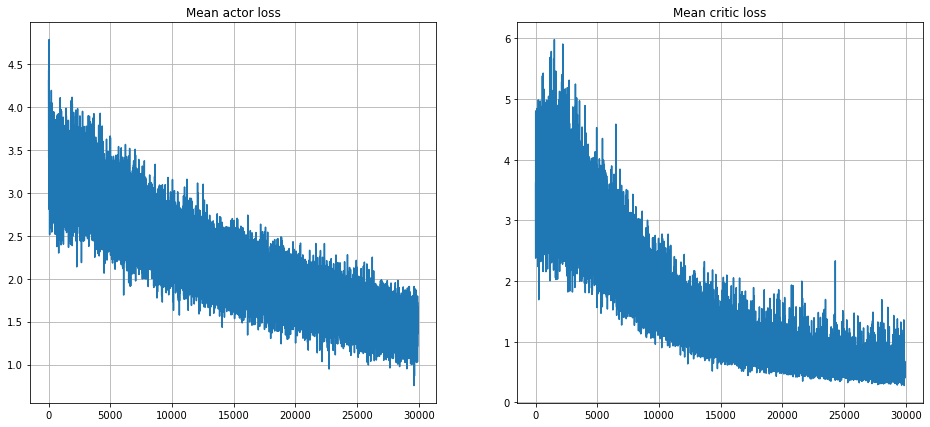

In [53]:
# training cycle
for t in tqdm(range(10000)):
    train(dataset, mcts, loss_function=selfplay_loss)
    
    if t % 100 == 0:
        draw()

In [34]:
# saving
#mcts.save("selfplay_pretrain_test")

# After pretraining

In [35]:
# MCTS with pretrained NN does not work better seemingly
# play_game_against_random_actor(env, mcts)

In [114]:
# clear data
dataset.clear()

In [115]:
# collect more data via selfplay
collect_data(env, mcts, dataset, self_play_NN, games=500)

<ipython-input-109-2294f2b5d7f7>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(games)):


  0%|          | 0/500 [00:00<?, ?it/s]

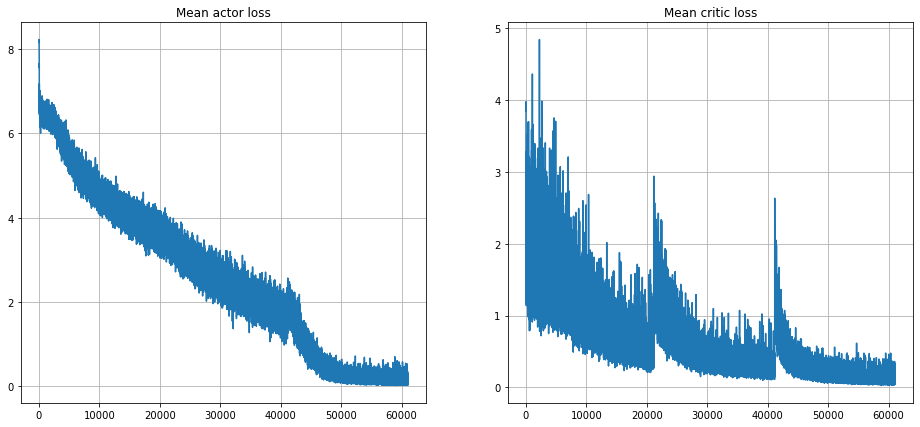

In [116]:
# train some more
for t in tqdm(range(20000)):
    train(dataset, mcts, loss_function=selfplay_loss)
    
    if t % 100 == 0:
        draw()

In [118]:
#mcts.save("third model")

# Data collection

We SHOULD collect data using MCTS policy, but it is too slow :(

In [48]:
def play_game(env, mcts, n_iter=1000):
    s = env.reset()
    renderer_env = deepcopy(env)
    done = False
    starting_player = env.game.current_player
    mcts.clear_tree(starting_player)
    
    states = []
    actions = []
    mcts_policies = []
    rewards = []    
    
    while not done:
        states.append(s)
        
        for _ in tqdm(range(n_iter)):
            simulator = deepcopy(env)
            mcts.plan(simulator)
            
        mcts_policy = mcts.get_policy()
        action = np.random.choice(np.arange(N_ACTIONS), p=mcts_policy)
        
        s, r, done, _ = env.step(action)
        
        actions.append(action)
        mcts_policies.append(mcts_policy)
        rewards.append(r)
        
        renderer_env.step(action)
        renderer_env.render()
        
        if not done:
            mcts.root_from_subtree(action)
            
    renderer_env.close()
            
    return states, actions, mcts_policies, compute_reward_to_go(rewards, starting_player)

In [ ]:
play_game(env, mcts)

## Evaluation

To evaluate NN, we can play with it against random actor and see if it wins. Spoiler: it does not.

Can't evaluate MCTS because it is too slow.

In [50]:
#mcts.load("second_model")

In [36]:
from tqdm import tqdm_notebook as tqdm

def play_game_NN_against_random_actor(env, mcts, show=False):
    '''
    Plays a game between NN policy and random actor.
    TODO: make a single playing function and use three actors: MCTS actor, NN actor, random actor.
    '''
    s = env.reset()
    if show: renderer_env = deepcopy(env)
    done = False
    t = 0
    R = 0
    
    while not done:
        if env.game.current_player == 0:
            allowed_actions = env.get_mirrored_action_mask()
            action = mcts.launch_NN_policy(s, allowed_actions)
        else:
            action = random.choice(env.get_mirrored_action_mask().nonzero()[0])
        
        s, r, done, _ = env.step(action)
        t += 1
        R += r
        
        if show: 
            renderer_env.step(action)
            renderer_env.render(fps=4)
    
    if show: renderer_env.close()
    
    return R, t

In [37]:
Rs = []
for _ in tqdm(range(20)):
    R, t = play_game_NN_against_random_actor(env, mcts, show=False)
    print(f"game result: (turns: {t}, reward: {R})")
    Rs.append(R)

print("Score: ", np.array(Rs).mean())

<ipython-input-37-b7bbf58da073>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(20)):


  0%|          | 0/20 [00:00<?, ?it/s]

game result: (turns: 200, reward: -0.6)
game result: (turns: 200, reward: -1.2)
game result: (turns: 200, reward: -3.3000000000000003)
game result: (turns: 200, reward: 3.3)
game result: (turns: 200, reward: 2.4000000000000004)
game result: (turns: 200, reward: -2.7755575615628914e-17)
game result: (turns: 200, reward: 0.9)
game result: (turns: 200, reward: 1.2)
game result: (turns: 200, reward: 0.6)
game result: (turns: 200, reward: -0.30000000000000004)
game result: (turns: 200, reward: 2.7)
game result: (turns: 200, reward: -0.6000000000000001)
game result: (turns: 200, reward: 1.8)
game result: (turns: 200, reward: 0.0)
game result: (turns: 200, reward: -5.1000000000000005)
game result: (turns: 200, reward: 2.7)
game result: (turns: 200, reward: 0.6)
game result: (turns: 200, reward: 1.2)
game result: (turns: 200, reward: 2.7)
game result: (turns: 200, reward: 1.8000000000000003)
Score:  0.54
